# Problem 15: Semi-supervised Learning

In this problem, we will consider _semi-supervised learning_, which falls between _unsupervised learning_ (i.e., learning from unlabeled datasets, like k-means) and _supervised learning_ (i.e., learning from completely labeled training data like the logistic regression algorithm).

Under the so-called _transductive semi-supervised formulation_, given a combination of labeled and unlabeled data, our goal is to use labeled and unlabeled data to assign labels to unlabeled data.

We will use the handwritten digit dataset which some of you may have seen previously. The data is a set of $8\times 8$ images reshaped as a vector of size 1x64 and each image represent a digit between 0 to 9. 

**Exercise 0** (0 points). Run the following code cell, which loads the digit dataset.

In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

digits = load_digits()

X = scale(digits.data)
y = digits.target

n_total_samples = len(y)
n_labeled_points = n_total_samples - 800

indices = np.arange(n_total_samples)
unlabeled_set = indices[n_labeled_points:]

y_train = np.copy(y)
y_train[unlabeled_set] = -1

In [2]:
import pandas as pd
from pandas.util import hash_pandas_object

def canonicalize_tibble(X):
    # Enforce Property 1:
    var_names = sorted(X.columns)
    Y = X[var_names].copy()

    # Enforce Property 2:
    Y.sort_values(by=var_names, inplace=True)
    
    # Enforce Property 3:
    Y.reset_index(drop=True, inplace=True)
    
    return Y

def solutions_are_equivalent(student_soln, B_hash):
    """Given two arrays, returns True iff they are
    equivalent.
    """
    df = pd.DataFrame(np.squeeze(student_soln))
    return hash_pandas_object(df).sum() == B_hash

def sorted_solutions_are_equivalent(student_soln, B_hash):
    """Given two arrays, returns True iff their sorted versions are
    equivalent.
    """
    df = pd.DataFrame(np.squeeze(student_soln))
    return hash_pandas_object(canonicalize_tibble(df)).sum() == B_hash

Here are the first five and last five images in the digit dataset. The plot shows the images with the correct label (first row) and unlabeled images (second row). Observe that `-1` is used for unlabeled points.

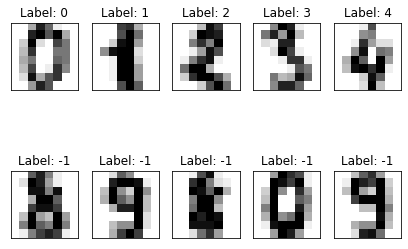

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 5))
index = [0,1,2,3,4,len(y)-1,len(y)-2,len(y)-3,len(y)-4,len(y)-5]
for i, ii in enumerate(index):
    image = digits.images[ii]
    sub = fig.add_subplot(2, 5, i+1)
    sub.imshow(image, cmap=plt.cm.gray_r)
    plt.xticks([])
    plt.yticks([])
    sub.set_title('Label: %i' %(y_train[ii]))
plt.show()

# Part 0: K-means clustering
In this part, we will use k-means clustering to label the unlabeled data. Here is the process:
1. First, cluster all images (labeled + unlabeled) using k-means clustering algorithm.
2. Then, find the most common label in each cluster (excluding -1 labels).
3. Finally, assign the most common label in each cluster to all unlabeled data inside the corresponding cluster

**Exercise 1** (2 points). Let's start with k-means clustering on the digits dataset. Suppose you are given a $n \times 64$ matrix of images (i.e., the data matrix $X$) and a $k \times 64$ matrix of initial centers. Implement a function, `find_clusters`, that uses the k-means clustering algorithm to assign a "cluster label" to each image. In other words, your function should return a 1-D Numpy array $y$ of length $n$ such that  $0 \leq y[i] < k$ indicates the index of the cluster the i'th image is closest to. 

In [4]:
def find_clusters(X, centers):
###
    from scipy.cluster.vq import kmeans, vq
    codebook , distortion= kmeans(X,centers)
    code, disct = vq(X,codebook)
    return code
###


In [5]:
# (0 Point) `find_cluters_dummy`: Test cell 1
labels_1 = find_clusters(X[:100],X[:10])
print("student solution", labels_1)

labels_solution = np.load("./resource/asnlib/publicdata/find_clusters_solution.npy")

assert labels_1.shape == (len(X[:100]),)
assert len(set(labels_1.tolist())) == 10

assert np.array_equal(labels_1, labels_solution)
assert np.array_equiv(labels_1, labels_solution)

print("\n(Passed!)")

student solution [0 1 2 3 4 5 6 7 8 9 0 1 6 3 4 5 6 7 8 5 0 1 8 3 4 9 6 7 8 5 0 3 5 5 6 5 0
 5 8 3 8 4 1 7 7 3 9 1 0 0 2 2 7 8 2 0 1 2 6 3 3 7 3 3 4 6 6 6 4 8 1 5 0 5
 9 2 8 2 0 0 1 7 6 3 8 1 7 1 6 3 1 3 3 1 7 6 8 4 3 8]

(Passed!)


In [6]:
# (2 points) `find_clusters`: Test cell
labels = find_clusters(X, X[:20])
print("student solution", labels)

assert labels.shape == (len(X),)
assert len(set(labels.tolist())) == 20

assert solutions_are_equivalent(labels, -1087113538337893740)

print("\n(Passed!)")

student solution [0 1 2 ... 8 5 8]

(Passed!)


**Exercise 2** (1 point). Given a cluster index for all images, `clustering`, and image labels, `y`, return a Numpy array of length `k`, such that the `i`-th element of this array indicates the most common label among **labeled images** in the `i`-th cluster. In the case of a tie for the most common label, return the value of the smallest label. If a cluster does not contain any labeled images, assign a label of `-1` to that cluster.

For example, suppose you execute the following.

```python
clustering = np.array([ 8, 5, 5, 8, 6, 7,  4, 1, 8, 7, 5,  8, 8])
y =          np.array([-1, 5, 6, 9, 6, 7, -1, 1, -1, 7, 6, -1, 3])
z = find_max_common_label_in_cluster(clustering, y, 10)
print(z)  # Output will be: [-1  1 -1 -1 -1  6  6  7  3 -1]
```

Consider every element where `clustering == 5`; these are the points assigned to Cluster 5. The corresponding labels, `y[clustering == 5]`, are `[5, 6, 6]`. Thus, the most common label in Cluster 5 is 6. Therefore, `z[5] == 6`.

Next, consider every element where `clustering == 4`. There is just one such point: `y[clustering == 4] == [-1]`, which is an unlabeled point. Therefore, `z[4] == -1`.

Now consider `clustering == 8`. Observe that `y[clustering == 8] == [-1,  9, -1, -1,  3]`. Among the **labeled** points, `3` and `9` occur once each, so they are tied in frequency. In this case, you should return the smallest label, 3.

Lastly, observe that `clustering` contains no instances of 0, 2, 3, or 9. The corresponding outputs in `z` have been set to -1.

In [7]:
def find_max_common_label_in_cluster(clustering, y, k):
###
# k = 10
# clustering = np.array([ 8, 5, 5, 8, 6, 7,  4, 1, 8, 7, 5,  8, 8])
# y = np.array([-1, 5, 6, 9, 6, 7, -1, 1, -1, 7, 6, -1, 3])
    from scipy import stats
    z = np.zeros(k)
    for i in range(k):
        if len(y[(clustering == i)&(y!=-1)]) == 0:
            z[i] = -1
        else:
                z[i] = stats.mode(y[(clustering == i)&(y!=-1)])[0]
    return z.astype(int)
###


In [8]:
# (0 point) `find_max_common_label_in_cluster_dummy`: Test cell
representatives_1 = find_max_common_label_in_cluster(labels_1,y_train[:100],10)

print("student solution", representatives_1)

assert len(representatives_1) == 10
representatives_solution = np.load("./resource/asnlib/publicdata/find_max_common_in_cluster_solution.npy")
assert np.array_equal(representatives_1, representatives_solution)
assert np.array_equiv(representatives_1, representatives_solution)

print("\n(Passed!)")

student solution [0 1 2 3 4 5 6 7 8 5]

(Passed!)


In [9]:
# (1 point) `find_max_common_label_in_cluster`: Test cell
representatives = find_max_common_label_in_cluster(labels,y_train,20)

print("student solution", representatives)

assert len(representatives) == 20

assert solutions_are_equivalent(representatives, 1882766301811886818)

print("\n(Passed!)")

student solution [ 0  1  8  2  4  9  6  7  8  5  7  1  1  3  4  2 -1  7  5  9]

(Passed!)


**Exercise 3** (2 points). Given a  $n \times 64$ matrix of images (i.e., the $X$ matrix), a vector of labels (for unlabeled data $y_{\mathrm{train}}[i]$ is equal to -1), and an initial value of cluster centers, write a function to update the label of unlabeled images. Your function should use the functions in Exercises 1 and 2 to find the clusters and the most common label in each cluster. Then, your function should update $y_{\mathrm{train}}$ for unlabeled images by the most common label of its cluster.  Your function should return a vector $y$ of length $n$ such that $y[i]$ indicates the label of each image. Your function should only update unlabeled data.

In [10]:
def update_labels_1(y_train, X, centers):
###
    labels_1 = find_clusters(X, centers)
    z = find_max_common_label_in_cluster(labels_1, y_train, len(y_train))
    for i in range(len(y_train)):
        if y_train[i] == -1:
            y_train[i] = z[labels_1[i]]
    return y_train 
###


In [11]:
# `update_labels_1`: Test cell
predicted_labels = update_labels_1(y_train,X,X[:20])

print("student solution", predicted_labels)

print("instructor's partial solution", np.load("./resource/asnlib/publicdata/update_labels_partial_solution.npy"))
update_labels1_solution = np.load("./resource/asnlib/publicdata/update_labels_partial_solution.npy")

assert predicted_labels.shape == y_train.shape
assert len(set(predicted_labels.tolist())) == 11

assert solutions_are_equivalent(predicted_labels, 3384812290756396889)

print("\n(Passed!)")

student solution [0 1 2 ... 8 9 8]
instructor's partial solution [0 1 2 ... 1 7 5]

(Passed!)


# Part 1: K-nearest neighbors

In this part, we will implement a completely supervised algorithm to label unlabeled images. That is, given a combination of labeled and unlabeled data, we use only labeled data to identify the label of unlabeled data.

For this purpose, we will use k-nearest neighbors. That is, for each unlabeled image, we will first find the $k$ labeled neighbors closest to that image, and determine a label based on those neighbors.

**Exercise 4** (1 point). Given one image, as a vector $\mathrm{img}$, and a $n \times 64$ matrix $X$ of labeled images, implement the function `k_nearest_neighbor` so that it finds the $k$ labeled points (from $X$) that are closest to $\mathrm{img}$. Your function should return the **index** (i.e., row numbers) of these points in $X$. Use Euclidean distance to calculate the distance between two images.

In [12]:
def k_nearest_neighbor(X, img, k):
###

    from numpy import linalg as LA

    # x = X[:n_labeled_points]
    # im = X[n_labeled_points+1]
    x = X
    im = img
    E = np.array(LA.norm(x-im, axis = 1))
    return E.argsort()[:k]

###


In [13]:
# (0 points) `k_nearest_neighbor_dummy`: Test cell

neighbours_1 = k_nearest_neighbor(X[:n_labeled_points],X[n_labeled_points+1],20)
print("student solution", neighbours_1)

k_nearest_neighbor_solution_1 = np.load("./resource/asnlib/publicdata/k_nearest_neighbor_solution_1.npy")

assert len(neighbours_1) == 20, "Neighbors don't match!" 
assert set(k_nearest_neighbor_solution_1)==set(neighbours_1), "Neighbors don't match!" 

print("\n(Passed!)")

student solution [689 655 771 946 765 732 467 966 929 970 751 177 673  27  14 356 429 665
  24  97]

(Passed!)


In [14]:
# (1 point) `k_nearest_neighbor`: Test cell
neighbours_2 = k_nearest_neighbor(X[:n_labeled_points],X[n_labeled_points+100],10)
print("student solution", neighbours_2)

assert len(neighbours_2) == 10, "Neighbors don't match!" 
assert sorted_solutions_are_equivalent(neighbours_2, 6404842348927980110), "Neighbors don't match!" 

print("\n(Passed!)")

student solution [777 349 869 875 326 355 797 866 787 346]

(Passed!)


**Exercise 5** (1 point). Suppose you are given the array of all labels (`y_train`) and an array of indices (`group`). Complete the function `most_common_label(y_train, group)` so that it determines and returns the most common label. In case of a tie for the most common label, return the value of the smallest label. 

For instance,

```python
   most_common_label(np.array([4, 2, 1, 1, 3, 2, 4, 2, 2, 2, 4]), np.array([2, 3, 5, 6])) == 1
```

In [15]:
def most_common_label(y_train, group):
###
    from scipy import stats
#     group =  np.array([2, 3, 5, 6])
#     y = np.array([4, 2, 1, 1, 3, 2, 4, 2, 2, 2, 4])
    m = stats.mode(y_train[group])[0]
    return m
###


In [16]:
# `most_common_label`: Test cell

###test 1
common_label_1 = most_common_label(y_train, neighbours_1)
print("test 1: student solution is", common_label_1)

assert common_label_1 == np.load("./resource/asnlib/publicdata/common_label_solution_1.npy"), "label is not correct!" 

###test 2
common_label_2 = most_common_label(y_train, neighbours_2)
print("test 2: student solution is", common_label_2)
assert common_label_2 == np.load("./resource/asnlib/publicdata/common_label_solution_2.npy"), "label is not correct!" 

print("\n(Passed!)")

test 1: student solution is [4]
test 2: student solution is [1]

(Passed!)


**Exercise 6** (2 points). Given a matrix of labeled images (i.e. $X_{\mathrm{labeled}}$) and a vector of coressponding labels (i.e. $y_{\mathrm{train}}$), use the functions in questions 4 and 5 to find the most common neighbor, $mcn$, of each unlabeled image $uimg$, in $X_{\mathrm{unlabeled}}$, and assign $mcn$ as a label for $uimg$. Your function should generate a (column) vector $y_{\mathrm{test}}$ such that $y_{\mathrm{test}}[i]$ stores the label of $X_{\mathrm{unlabeled}}[i]$.

In [17]:
def update_labels_2(y_train, X_labeled, X_unlabeled, k):
###
    y = np.zeros(len(X_unlabeled))
    for i, img in enumerate(X_unlabeled):
        neighbor_1 = k_nearest_neighbor(X_labeled, img, k)
        y[i] =  most_common_label(y_train, neighbor_1)
    return y
###


In [18]:
X_unlabeled = X[n_labeled_points:]

y_test = np.zeros(len(X_unlabeled))
print(y_test)

y_test = np.zeros(len(X_unlabeled),order='F')
print(y_test)

print(update_labels_2(y_train,X[:n_labeled_points],X[n_labeled_points:],20))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [19]:
# `update_labels_2`: Test cell

predicted_labels = update_labels_2(y_train,X[:n_labeled_points],X[n_labeled_points:],20)

assert len(predicted_labels) == len(X[n_labeled_points:])
assert len(set(predicted_labels.tolist())) == 10

update_labels2_solution = np.load("./resource/asnlib/publicdata/update_labels_2_partial_solution.npy")

assert np.array_equal(predicted_labels[:400], update_labels2_solution), "Labels are incorrect"
assert np.array_equiv(predicted_labels[:400],  update_labels2_solution),"Labels are incorrect"

assert solutions_are_equivalent(predicted_labels, -5480449408506454971) 
print("\n(Passed!)")


(Passed!)


**Exercise 7** (1 point). Now let's check the accuracy of labeling for these two methods. We calculate accuracy using the following formula:

$\mathrm{accuracy} = \frac{\mathrm{number \; of \; correctly \; labeled \; test \; data}}{\mathrm{number \; of \; test \; data}}$

Given the predicted labels, $y_{\mathrm{test}}$, and the correct labels $y$, your function should return the accuracy of this labeling. You may assume the labels array $y$ only contains labels for unlabeled images.

In [20]:
def calculate_accuracy(y_test, y):
    ###
    s = 0
    for i in range(len(y_test)):
        if y_test[i] == y[i]:
            s +=1

    return s/len(y_test)
    ###


In [21]:
# `calculate_accuracy`: Test cell

n_total_samples = len(y)
n_labeled_points = n_total_samples - 1000
indices = np.arange(n_total_samples)
unlabeled_set = indices[n_labeled_points:]

###test 1
y_train_1 = np.copy(y)
y_train_1[unlabeled_set] = -1
y_1 = update_labels_1(y_train_1, X, X[:100])
first_method_accuarcy = calculate_accuracy(y_1[n_labeled_points:], y[n_labeled_points:])
print("The first method accuracy is 0.89")
assert (abs(first_method_accuarcy - 0.89) <= 1e-5), "Accuracy is not correct!"

###test 2
y_train_2 = np.copy(y)
y_train_2[unlabeled_set] = -1
y_2 = update_labels_2(y_train_2[:n_labeled_points], X[:n_labeled_points],X[n_labeled_points:], 100)
second_method_accuarcy = calculate_accuracy(y_2, y[n_labeled_points:])
print("The second method accuracy is 0.858")
assert (abs(second_method_accuarcy - 0.858) <= 1e-5), "Accuracy is not correct!"

print("\n(Passed!)")

The first method accuracy is 0.89
The second method accuracy is 0.858

(Passed!)


**Fin!** Remember to test your solutions by running them as the autograder will: restart the kernel and run all cells from "top-to-bottom." Also remember to submit to the autograder; otherwise, you will **not** get credit for your hard work!